In [1]:
%load_ext autoreload

In [6]:
import h2o
import os
import pandas as pd
from h2o.estimators import *
from h2o.grid import *
from h2o.automl import H2OAutoML

## Format data

In [77]:
## Read data ##
A_train_target = pd.read_parquet('data/A/parquet/train_targets.parquet')
A_test = pd.read_parquet('data/A/parquet/X_test_estimated.parquet')
A_train_estimated = pd.read_parquet('data/A/parquet/X_train_estimated.parquet')
A_train_observed = pd.read_parquet('data/A/parquet/X_train_observed.parquet')

B_train_target = pd.read_parquet('data/B/parquet/train_targets.parquet')
B_test = pd.read_parquet('data/B/parquet/X_test_estimated.parquet')
B_train_estimated = pd.read_parquet('data/B/parquet/X_train_estimated.parquet')
B_train_observed = pd.read_parquet('data/B/parquet/X_train_observed.parquet')

C_train_target = pd.read_parquet('data/C/parquet/train_targets.parquet')
C_test = pd.read_parquet('data/C/parquet/X_test_estimated.parquet')
C_train_estimated = pd.read_parquet('data/C/parquet/X_train_estimated.parquet')
C_train_observed = pd.read_parquet('data/C/parquet/X_train_observed.parquet')
###############

## Concatinate train data ##
A_train_concat = pd.concat([A_train_observed, A_train_estimated], axis=0)
B_train_concat = pd.concat([B_train_observed, B_train_estimated], axis=0)
C_train_concat = pd.concat([C_train_observed, C_train_estimated], axis=0)

# Set index to date_forecast
A_train_concat.set_index('date_forecast', inplace=True)
B_train_concat.set_index('date_forecast', inplace=True)
C_train_concat.set_index('date_forecast', inplace=True)

# Drop date_calc column
A_train_concat.drop(columns=['date_calc'], inplace=True)
B_train_concat.drop(columns=['date_calc'], inplace=True)
C_train_concat.drop(columns=['date_calc'], inplace=True)
############################

## Format test data to same as train data ##
A_test.set_index('date_forecast', inplace=True)
B_test.set_index('date_forecast', inplace=True)
C_test.set_index('date_forecast', inplace=True)

# Drop date_calc column
A_test.drop(columns=['date_calc'], inplace=True)
B_test.drop(columns=['date_calc'], inplace=True)
C_test.drop(columns=['date_calc'], inplace=True)
############################################

## Cast train_target's RangeIndex to DatetimeIndex ##
A_train_target.set_index('time', inplace=True)
B_train_target.set_index('time', inplace=True)
C_train_target.set_index('time', inplace=True)
#####################################################

## Add 'pv_measurement' column from train_target to train data ##
A_train_concat['pv_measurement'] = A_train_target['pv_measurement']
B_train_concat['pv_measurement'] = B_train_target['pv_measurement']
C_train_concat['pv_measurement'] = C_train_target['pv_measurement']

# Remove all rows with NaN values in 'pv_measurement' column in train_concat
A_train_concat.dropna(subset=['pv_measurement'], inplace=True)
B_train_concat.dropna(subset=['pv_measurement'], inplace=True)
C_train_concat.dropna(subset=['pv_measurement'], inplace=True)
###################################################################

## Check that every index in train_concat is in train_target ##
if len(A_train_concat.index) == len(A_train_target.index) or len(B_train_concat.index) == len(B_train_target.index) or len(C_train_concat.index) == len(C_train_target.index):
    print('Same length')
else:
    # Remove indicies in A_train_target that are not in A_train_concat
    A_train_target = A_train_target[A_train_target.index.isin(A_train_concat.index)]
    B_train_target = B_train_target[B_train_target.index.isin(B_train_concat.index)]
    C_train_target = C_train_target[C_train_target.index.isin(C_train_concat.index)]
    
    if len(A_train_concat.index) != len(A_train_target.index) or len(B_train_concat.index) != len(B_train_target.index) or len(C_train_concat.index) != len(C_train_target.index):
        print('Not same length')
################################################################

## H2O

In [78]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,1 hour 15 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.4
H2O_cluster_version_age:,"7 days, 22 hours and 50 minutes"
H2O_cluster_name:,H2O_from_python_stinky_ixpoqx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.889 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


# Test on only data from A

In [89]:
X_train = A_train_concat
y_train = A_train_target

X_test = A_test

# Convert to h2o frame
X_train = h2o.H2OFrame(X_train)
y_train = h2o.H2OFrame(y_train)
X_test = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


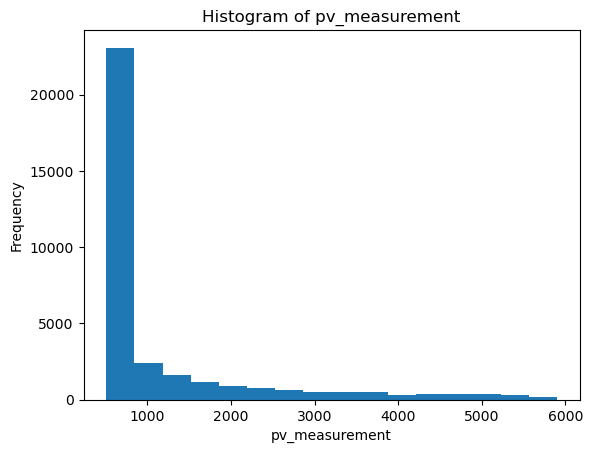

breaks,counts,mids_true,mids,widths
337.26,nan,nan,nan,nan
674.52,23079,13.09,505.89,337.26
1011.78,2438,168.63,843.15,337.26
1349.04,1626,337.26,1180.41,337.26
1686.3,1163,505.89,1517.67,337.26
2023.56,879,674.63,1854.93,337.26
2360.82,782,843.48,2192.19,337.26
2698.08,649,1011.78,2529.45,337.26
3035.34,510,1180.41,2866.71,337.26
3372.6,513,1349.7,3203.97,337.26


In [91]:
X_train['pv_measurement'].hist()

In [92]:
## Split data to train, validation and test set ##
train, valid, test = X_train.split_frame(ratios=[0.7, 0.15], seed=42)
print('train: %d, valid: %d, test: %d' % (train.nrows, valid.nrows, test.nrows))

train: 23948, valid: 5011, test: 5102


In [93]:
## Set target and input variables ##
y = 'pv_measurement'
x = list(set(train.names))

## H2O XGBoost

In [116]:
xgb = H2OXGBoostEstimator(model_id='XGBoost', ntrees=300, stopping_rounds=3, stopping_tolerance = 1e-3, stopping_metric="rmse", seed=42)
hyper_params = {'max_depth': [5, 7, 9, 10, 12, 13, 15, 20]}
grid_id = "max_depth_grid"
search_criteria={"strategy":"Cartesian"}
xgb_grid = H2OGridSearch(model=xgb, hyper_params=hyper_params, grid_id=grid_id, search_criteria=search_criteria)

%time xgb_grid.train(x=x, y=y, training_frame = train, validation_frame = valid)

xgboost Grid Build progress: |

███████████████████████████████████████████████████| (done) 100%
CPU times: user 277 ms, sys: 32.8 ms, total: 309 ms
Wall time: 21.7 s


,max_depth,model_ids,residual_deviance
,10.0,max_depth_grid_model_28,175198.9487663
,10.0,max_depth_grid_model_20,175223.9539687
,5.0,max_depth_grid_model_17,180048.6325784
,9.0,max_depth_grid_model_19,180349.8363556
,9.0,max_depth_grid_model_27,180349.8363556
,12.0,max_depth_grid_model_21,180905.0281145
,12.0,max_depth_grid_model_29,181013.3255508
,7.0,max_depth_grid_model_18,182083.1438472
,7.0,max_depth_grid_model_26,182306.7530290
,5.0,max_depth_grid_model_25,183071.9533556


In [117]:
sorted_xgb = xgb_grid.get_grid(sort_by="rmse", decreasing=False)
sorted_xgb.sorted_metric_table()

,,max_depth,model_ids,rmse
0,,10.0,max_depth_grid_model_28,418.567735
1,,10.0,max_depth_grid_model_20,418.597604
2,,5.0,max_depth_grid_model_17,424.321379
3,,9.0,max_depth_grid_model_19,424.676155
4,,9.0,max_depth_grid_model_27,424.676155
5,,12.0,max_depth_grid_model_21,425.329317
6,,12.0,max_depth_grid_model_29,425.456608
7,,7.0,max_depth_grid_model_18,426.712015
8,,7.0,max_depth_grid_model_26,426.973949
9,,5.0,max_depth_grid_model_25,427.869084


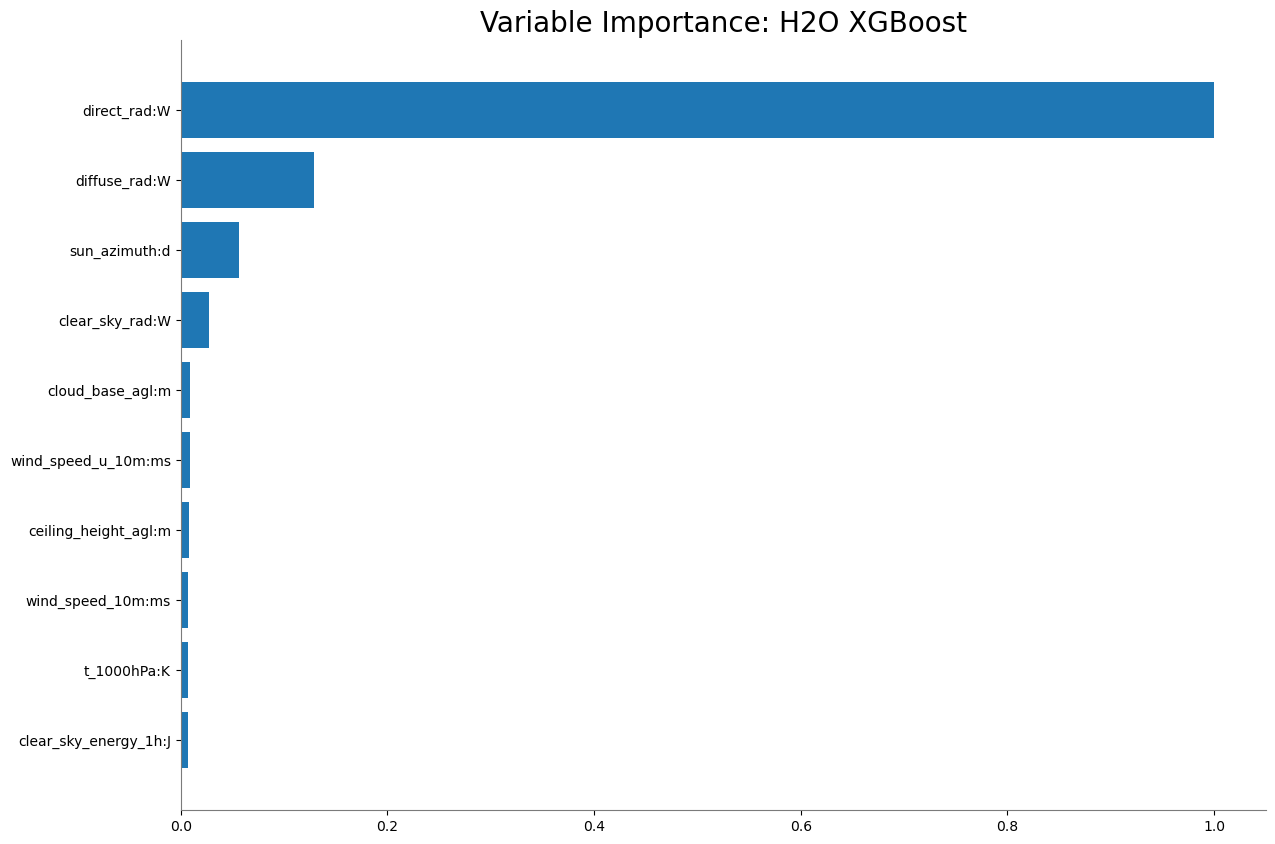

<Figure size 640x480 with 0 Axes>

In [96]:
xgb.varimp_plot()

In [97]:
xgb_def_pred = xgb.predict(valid)
xgb_def_pred.cbind(valid['pv_measurement'])

xgboost prediction progress: |███████████████████████████████████████████████████| (done) 100%


predict,pv_measurement
2379.07,2163.26
2607.65,2730.86
735.294,1057.54
-10.2065,0
-6.28486,6.38
1778.69,2464
10.2016,10.78
2400.25,0
3999.5,0
905.681,317.02


In [98]:
default_xgb_per = xgb.model_performance(valid)

## H2O Deep Learning

In [99]:
dl = H2ODeepLearningEstimator(seed=42, model_id='DeepLearning', nfolds=0, keep_cross_validation_predictions=False)
%time dl.train(x=x, y=y, training_frame = train, validation_frame = valid)

deeplearning Model Build progress: |

/home/stinky/.local/lib/python3.10/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [snow_drift:idx, elevation:m]
  warnings.warn(mesg["message"], RuntimeWarning)


█████████████████████████████████████████████| (done) 100%
CPU times: user 185 ms, sys: 15.2 ms, total: 200 ms
Wall time: 19.1 s


Model Details
=============
H2ODeepLearningEstimator : Deep Learning
Model Key: DeepLearning


Status of Neuron Layers: predicting pv_measurement, regression, gaussian distribution, Quadratic loss, 49,601 weights/biases, 598.1 KB, 239,480 training samples, mini-batch size 1
    layer    units    type       dropout    l1    l2    mean_rate              rate_rms               momentum    mean_weight            weight_rms           mean_bias           bias_rms
--  -------  -------  ---------  ---------  ----  ----  ---------------------  ---------------------  ----------  ---------------------  -------------------  ------------------  -----------------------
    1        45       Input      0.0
    2        200      Rectifier  0.0        0.0   0.0   0.07429235904873996    0.1839827299118042     0.0         0.00828451523019127    0.12404525279998779  0.4200087475605514  0.1112501323223114
    3        200      Rectifier  0.0        0.0   0.0   0.08028816345060913    0.09428876638412476    0.0         -0.034074809276648646  0.07934105396270752  0.910702969214394   0.05892479419708252
    4        1        Linear                0.0   0.0   0.0011685826109533082  0.0005424846895039082  0.0         0.0027319911461381706  0.05076722800731659  0.5192510232604484  1.0971281125650402e-154

ModelMetricsRegression: deeplearning
** Reported on train data. **

MSE: 197414.1872715658
RMSE: 444.31316351371566
MAE: 219.26040836804353
RMSLE: NaN
Mean Residual Deviance: 197414.1872715658

ModelMetricsRegression: deeplearning
** Reported on validation data. **

MSE: 192202.03403152176
RMSE: 438.40852413191254
MAE: 216.69767270916927
RMSLE: NaN
Mean Residual Deviance: 192202.03403152176

Scoring History: 
    timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_deviance    training_mae    training_r2    validation_rmse    validation_deviance    validation_mae    validation_r2
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  -------------------  --------------  -------------  -----------------  ---------------------  ----------------  ---------------
    2023-10-11 14:56:56  0.000 sec                     0         0             0          nan              nan                  nan             nan            nan                nan                    nan               nan
    2023-10-11 14:57:00  5.305 sec   5577 obs/sec      1         1             23948      540.255          291875               283.037         0.782626       516.373            266641                 271.672           0.805465
    2023-10-11 14:57:07  11.687 sec  11521 obs/sec     5         5             119740     486.856          237028               252.46          0.823473       468.225            219234                 245.329           0.840051
    2023-10-11 14:57:12  17.019 sec  13916 obs/sec     9         9             215532     444.313          197414               219.26          0.852976       438.409            192202                 216.698           0.859774
    2023-10-11 14:57:13  18.412 sec  14400 obs/sec     10        10            239480     479.958          230360               291.497         0.82844        480.533            230912                 291.626           0.831532
    2023-10-11 14:57:14  18.669 sec  14396 obs/sec     10        10            239480     444.313          197414               219.26          0.852976       438.409            192202                 216.698           0.859774

Variable Importances: 
variable                        relative_importance    scaled_importance    percentage
------------------------------  ---------------------  -------------------  --------------------
sun_azimuth:d                   1.0                    1.0                  0.05865902991894898
snow_density:kgm3.nan           0.5577160716056824     0.5577160716056824   0.032715083730596416
direct_rad:W                    0.504974901676178      0

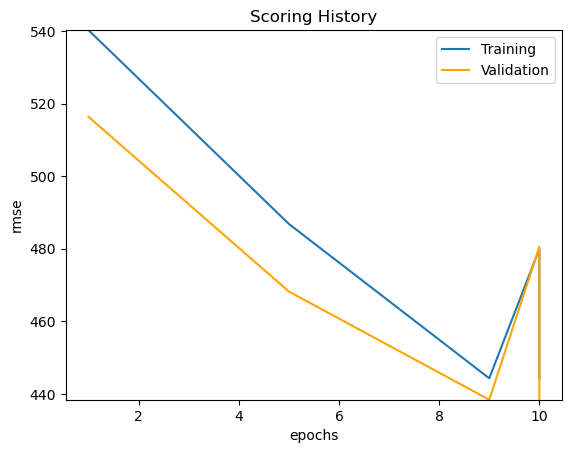

In [100]:
dl.plot()

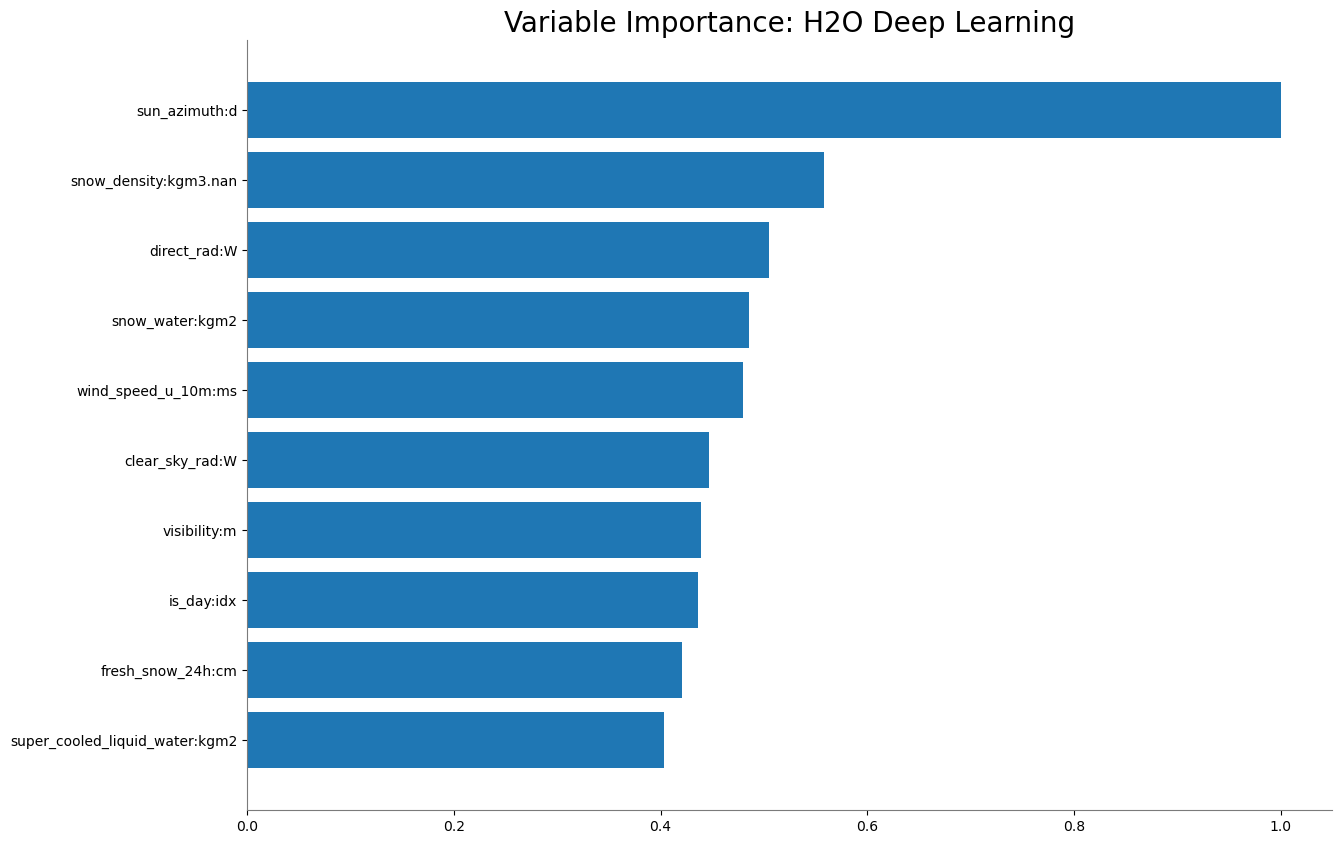

<Figure size 640x480 with 0 Axes>

In [101]:
dl.varimp_plot()